# Diagnosing and plotting maps of internal tide for AMM60 validation paper

** Summary: **
Diagnostics for the internal tide. Aim: make maps of amplitude and variance of IT for z<200m

** Notebook: ** internaltidemap_AMM60_paper.ipynb

** Author: ** JP 12 Sept 2016

** Changelog: **

2D maps from 3D NEMO diagnostics:

* 12 Sept 2016: Get started
* 24 Oct 2016: Simple PAP animation of pycnocline depth in 1x1 deg box
* 2 Nov 2016: Abstracted heavy lifting into .py script. Notebook wrapped used to document dicussion and thoughts.
* 3 Nov 2016: Compiled June / July 2012 data and chunked analysis into 3days bites
* 4 Nov 2016: presentation of 3 day chunks with IT stats and harmonic phase
* 28 Nov: std vs time for whole domain

## Introduction

The aim is to make maps of the internal tide map for the AMM60. 


### Assumptions
* (2D analysis) Assumed that analysis between the surface and the 200m isobath is sufficient to remove contributions from the main (Atlantic) thermocline. However I am not sure so mask out the deep water in the results. It would be good to show $\delta$ both on and offshelf but I do not know how to interpret the offshelf diagnostic; what causes the large scale spatial patterns?

### Comments, to do list:
* Maybe add new diagnostics: e.g. in deep water, and wave potential energy?
* In the pre-amble I talk about energy diagnostics in a couple of ways but do not diagnose it at all.
* Add in another time period, investigate spring neap variability? If we did only one analysis period, 5 days over spring tides would be better.
* investigate the stratification masking threshold and whether $\sigma$ is elevated near fronts.

In [1]:
import numpy as np
import numpy.ma as ma

from netCDF4 import Dataset
import scipy.io # reading in mat files
#import iris.quickplot as qplt

from datetime import datetime, timedelta
import matplotlib.dates as mdates

import matplotlib.pyplot as plt  # plotting

from sympy import * 
from __future__ import division

init_printing()  # for sympy

%matplotlib inline

In [1]:
# Check host name
import socket
hostname = socket.gethostname()
print hostname

livmaf.home


In [2]:
import getpass
username = getpass.getuser()
print username

jeff


#Part I: Definitions

Define 3 variables to quantify the internal tide:

0) depth mean density, $\overline{\rho}(t)$

1) Potential energy anomaly, {PEanom, $\phi$} 

2) Normalised first moment of stratification

** Potential Energy anomaly **

When the depth bins are equal, the potential energy anomaly, {PEanom, $\phi$} reduces to $\sum_k z_k (\rho_k - \overline{\rho} )$ 

Since, when $\Delta z_k =$ constant:
$$
\begin{align}
\phi &&=&& \frac{1}{H}\int_{-H}^{0} (\rho -\overline{\rho}) z \,dz \\
&&\approx && \frac{1}{n\Delta z}\sum_{k=1}^n (\rho_k-\overline{\rho}) z_k (\Delta z)_k  \\
&& = &&  \sum_{k=1}^n (\rho_k-\overline{\rho}) z_k 
\end{align}
$$

** Normalised 1st moment of stratification, $\delta$ **


Define the depth of the pycnocline, $\delta$, as a normalised 1st moment of stratification:

$$
\begin{align}
\delta = \frac{m_1}{m_0}
\end{align}
$$

where
$$
\begin{align}
m_n &&=&& \int_{-H}^{0} z^n \frac{\partial \rho}{\partial z} \,dz  \\ 
\end{align}
$$
and depth mean density is given as
$$
\begin{align}
\overline{\rho}(t) &&=&&  \frac{m_0}{H} 
\end{align}
$$

Then, applying the chain rule:
$$
\begin{align}
\delta(t) &&=&& H(t) \frac{  \rho_{bed}(t) - \overline{\rho}(t)   }{  \rho_{top}(t) - \rho_{bed}(t) }
\end{align}
$$

## Notes on the pycnocline depth and variance diagnostic

$$
\begin{align}
\delta(x,y,\zeta,t) && \equiv && \frac{ m_1(x,y,\zeta,t) }{ m_0(x,y,\zeta,t) } \\
&& = && \left\{ \int_\zeta^0 z \frac{\partial \rho}{\partial z} \, dz \right\} {\Large\div} \
\left\{ \int_\zeta^0  \frac{\partial \rho}{\partial z} \, dz \right\} \\
 &&=&& -\zeta(x,y,t) \frac{  \rho(x,y,\zeta,t) - \overline{\rho}^\zeta(x,y,\zeta,t)   }{  \rho(x,y,0,t) - \rho(x,y,\zeta,t) }
\end{align}
$$


Note that this definition is independant of (x,y) space. So, if $\zeta=\zeta(x,y)$ is the time averaged depth of a model level then this is still meaningful, indeed a useful way to remove the main thermocline contribution to the diagnostic.

However if model layers are chosen to define the depth of integration then $\zeta=\zeta(x,y,t)$, and then $\delta=\delta(x,y,\zeta,t)$. If $\zeta(x,y,t)$ fluctuates significantly with the tide is this likely to be a problem with the diagnostic? Consider two extreme cases: i) integration is taken over the full water column, ii) the depth integration limiting sigma level is at the pycnocline.

** 1) Full water column **
If $\zeta=\zeta_{pyc}$ is the pycnocline depth such that $\rho(x,y,\zeta,t)=\rho_{pyc}$ is independant of time
$$
\begin{align}
\delta(x,y,\zeta_{pyc},t) && \equiv && -\zeta_{pyc}(x,y,t) \frac{  \rho(x,y,\zeta_{pyc},t) - \overline{\rho}^\zeta(x,y,\zeta_{pyc},t)   }{  \rho(x,y,0,t) - \rho(x,y,\zeta_{pyc},t) }
\end{align}
$$
Then $\delta$ varies with $-\zeta_{pyc}(x,y,t)$, the pycnocline depth.


** 2) Integration to the pycnocline **


If $\zeta$ is the sea bed $H(x,y)>0$, independant of time
$$
\begin{align}
\delta(x,y,-H,t) && \equiv && H(x,y) \frac{  \rho(x,y,-H,t) - \overline{\rho}^\zeta(x,y,-H,t)   }{  \rho(x,y,0,t) - \rho(x,y,-H,t) }
\end{align}
$$
Then $\delta$ varies with $\overline{\rho}^\zeta(x,y,-H,t)$, the depth averaged density.



These two scenarios seem to produce different $\delta$. Are they equivalent?

Assume a two layer fluid, such that $\rho_0$ for $0>z>-d$ and $\rho_b$ for $-d>z>-H$.

Then **1)**
$$
\begin{align}
\delta(x,y,-H,t) && \equiv && H(x,y) \frac{  \rho_b - \overline{\rho}^\zeta(x,y,-H,t)   }{  \rho_0 - \rho_b } \\
&&=&&    \rho_b \frac{ H(x,y)  }{  \rho_0 - \rho_b }  -   \overline{\rho}^\zeta(x,y,-H,t)\frac{ H(x,y)  }{  \rho_0 - \rho_b } \\
&&=&&    \rho_b \frac{ H(x,y)  }{  \rho_0 - \rho_b }  -   (\frac{d}{H}\rho_0 + \frac{(H-d)}{H}\rho_b )\frac{ H(x,y)  }{  \rho_0 - \rho_b } \\
&&=&&    \rho_b \frac{ H(x,y)  }{  \rho_0 - \rho_b }  -   \frac{ (d\rho_0 + (H-d)\rho_b )  }{  \rho_0 - \rho_b } \\
&&=&&     -   d \\
\end{align}
$$

Conversely, ** 2) **

$$
\begin{align}
\delta(x,y,\zeta_{pyc},t) && \equiv && -\zeta_{pyc}(x,y,t) \frac{  \rho(x,y,\zeta_{pyc},t) - \overline{\rho}^\zeta(x,y,\zeta_{pyc},t)   }{  \rho(x,y,0,t) - \rho(x,y,\zeta_{pyc},t) }  \\
&& = && \zeta_{pyc}(x,y,t) \\
&& = &&  -d
\end{align}
$$



It would appear that the two distinct scenarios are equivalent, even for time varying sigma levels. This is perhaps an artificat of the two layer flow special case... And warrants a bit of extra thought.

Actually common sense would point out that as long as $\rho_z$ is small at $z=\zeta$ then it will not contribe to the calculation of $\delta$ regardless of how much it might oscillate in depth.

Pinning down the depth of the Atlantic mode water is not so straight forward without lots of  diagnostics. Not having the internal wave diagnostics working in deep water may not be a problem if our interest is on the shelf.

By inspection of the FASTNEt LA mooring, truncating the depth integral to 1000m should be adequate.



# Wave energy
It might be desirable to compute the wave energy in the internal wave field.
The easiest way to do this would be from the potential energy associated with the displacement.
Following Kundu
(http://www3.nd.edu/~fthomas/Kundu_Fluid_Mechanics.pdf 7.150 p302)

$$
E_p = \frac{1}{2}N^2 \rho_0 \zeta^2
$$

is the potential energy per unit volume, where $\zeta$ is the displacement amplitude. To be honest these sums need to be carefully done to ensure they are appropriate for the shallow water problem but I would expect that in shelf sea the potential energy would be given by:

$$
E_p \approx \frac{g\Delta \rho}{2 H}  \delta^2
$$

for displacement variance $\delta$, top to bottom density difference $\Delta \rho$ over a depth $H$. Though alternatively $N$ could be given by the thermocline maximum...

#Part II: AMM60 Diagnostics. Starting afresh with 4D NEMO data.
Here load in thermocline diagnostic and process these data

Data comes from Karen's ARCHER simulation:

`/work/n01/n01/kariho40/NEMO/NEMOGCM_jdha/dev_r4621_NOC4_BDY_VERT_INTERP/NEMOGCM/CONFIG/AMM60smago/EXPD376/`

Copied data for 2012 June - Aug 9th

`
livljobs2 jelt $ scp jelt@login.archer.ac.uk:/work/n01/n01/kariho40/NEMO/NEMOGCM_jdha/dev_r4621_NOC4_BDY_VERT_INTERP/NEMOGCM/CONFIG/AMM60smago/EXPD376/OUTPUT/AMM60_1h_2012*0120[678]??_diagIT_grid_T.nc /projectsa/FASTNEt/jelt/AMM60/RUNS/2010_2013/IT/.
`

Also use the  across a single mooring file to plot the SSH
scp jelt@login.archer.ac.uk:/work/n01/n01/kariho40/NEMO/NEMOGCM_jdha/dev_r4621_NOC4_BDY_VERT_INTERP/NEMOGCM/CONFIG/AMM60smago/EXPD376/OUTPUT/AMM60_1h_20120601_20120601_fastnet_ST4_grid_T.nc

In [3]:
from amm60_data_tools import window_strat # compute running window filtered stratification



In [3]:
#%%writefile internaltidemap_AMM60_paper.py
# %load internaltidemap_AMM60_paper.py
#
# internaltidemap_AMM60_paper.py
#
# Diagnostics for the internal tide. Aim: make maps of amplitude and variance of IT for z<200m
#
# Origin: internaltidemap_AMM60_paper.ipynb
# jpolton 2/11/16
if(1): # Skip data loading and processing
    from netCDF4 import Dataset
    import numpy as np
    import numpy.ma as ma # masks
    import datetime

    import os # Note sure I use this
    import glob # For getting file paths
    import copy # For deep copying variables
    from amm60_data_tools import NEMO_fancy_datestr # convert NEMO time 
    from amm60_data_tools import delta_diagnose # compute pycnocline depth and variance. Incl running window filter
    from amm60_data_tools import window_strat # compute running window filtered stratification

    import matplotlib.colors as colors # colorbar with log distribution
    import matplotlib.pyplot as plt  # plotting
    %matplotlib inline


    ##############################################################################
    # Check host name and username.
    # Depending on machine and modify path tree and flag to load partial data set
    import socket
    hostname = socket.gethostname()

    import getpass
    username = getpass.getuser()

    if 'livmaf' in hostname and username in ['jeff','jelt']:
        dirroot = '/Volumes'
        speedflag = True # only load in one file
    elif 'livljobs' in hostname and username in ['jeff','jelt']:
        dirroot = ''
        speedflag = True # only load in one file
    else:
        dirroot = ''
        speedflag = False

    ##############################################################################
    # Define functions for plotting multi subplot figure 
    ##############################################################################

    # Plot the time mean depth and density fields
    #############################################
    def plotit(x,y,var,label,isubplot):
        plt.subplot(2, 2, isubplot)
        plt.pcolormesh(x, y, var )
        plt.colorbar()
        plt.ylabel('lat')
        plt.xlabel('lon')
        plt.title(label)


    # Plot map of thermocline variance and depth
    ############################################
    def plotit_sub(x,y,var,label,clim,s_subplot):
        plt.subplot(int(s_subplot[0]), int(s_subplot[1]), int(s_subplot[2]) )
    #    plt.pcolormesh(x, y, var, cmap='nipy_spectral')
    #    plt.colorbar()


        cs = plt.pcolormesh(x,y,var, cmap=plt.cm.gnuplot)
        cs.cmap.set_under('grey')
        cs.set_clim(clim)
        cb = plt.colorbar(cs, extend="max") # Extend the upper end of the colorbar    

        plt.ylabel('lat')
        plt.xlabel('lon')
        plt.ylim([+45,+63])
        plt.xlim([-14,+14])
        plt.title(label)


    # Plot map of thermocline variance and depth. (As above but on log colour scale)
    ############################################
    def plotit_sub_log(x,y,var,label,clim,s_subplot):
        plt.subplot(int(s_subplot[0]), int(s_subplot[1]), int(s_subplot[2]) )

    #    cs = plt.pcolormesh(x,y,var, cmap=plt.cm.gnuplot)
        cs = plt.pcolormesh(x,y,var, cmap=plt.cm.gnuplot,
                            norm=colors.LogNorm(vmin=clim[0], vmax=clim[1]))
        cs.cmap.set_under('grey')
        cb = plt.colorbar(cs, extend="max") # Extend the upper end of the colorbar    
        #cb.set_ticks(range(clim[0],clim[1]+1))
        #cb.set_ticklabels(range(clim[0],clim[1]+1))
        cb.set_ticks(range(1,11))
        cb.set_ticklabels(range(1,11))

        plt.ylabel('lat')
        plt.xlabel('lon')
        plt.ylim([+45,+63])
        plt.xlim([-14,+14])
        plt.title(label)

        

    ##############################################################################
    # Set stuff up
    ##############################################################################
    dirnameK = dirroot+'/projectsa/FASTNEt/kariho40/AMM60/RUNS/2010_2013/IT/' # 2010 diagnostics
    dirname = dirroot+'/projectsa/FASTNEt/jelt/AMM60/RUNS/2010_2013/IT/' # 2012 diagnostics
    region = 'Celtic'
    #region = 'Malin'
    #region = 'NSea'

    data_flag = '200m'

    #filename = 'AMM60_1h_20100306_20100306_diagIT_grid_T_200m.nc' # Original (March) with mask problems
    #filename = 'AMM60_1h_20100306_20100307_diagIT_grid_T.nc' # New (March) with fixed mask
    #filename = 'AMM60_1h_20100704_20100708_diagIT_grid_T.nc' # July 2010
    #filename = 'AMM60_1h_20120601_20120610_diagIT_grid_T.nc' # June A 2012
    #filename = 'AMM60_1h_20120611_20120620_diagIT_grid_T.nc' # June B 2012
    #filename = 'AMM60_1h_20120621_20120630_diagIT_grid_T.nc' # June C 2012
    #filename = 'AMM60_1h_20120701_20120710_diagIT_grid_T.nc' # July A 2012
    #filename = 'AMM60_1h_20120711_20120720_diagIT_grid_T.nc' # July B 2012
    #filename = 'AMM60_1h_20120721_20120730_diagIT_grid_T.nc' # July C 2012
    #filename = 'AMM60_1h_20120731_20120809_diagIT_grid_T.nc' # July D 2012
    varsurf = 'rhop_surf'
    varbot = 'rhopc_bot'
    varave = 'rhop_ave'
    vardep = 'depth_rhopc'
    varnlev = 'nlev'
    print 'Diagnostics are calculated over the upper 200m'


    ##############################################################################
    ## Load in static files: bathymetry and nlev data
    # the actual bathymetry (not the stuff that gets clipped at 200m)
    ##############################################################################
    b = Dataset(dirroot+'/projectsa/FASTNEt/kariho40/AMM60/BATHY/GEBCO2014/BATHY_NOSMOOTH/bathyfile_AMM60.nc')

    bathy = b.variables['Bathymetry'][:] # (y, x)
    #load lat and lon
    blat = b.variables['lat'][:] # (y,x)
    blon = b.variables['lon'][:] # (y,x)

    b.close()

    ## Load in the vertical levels nlev diagnosics from an old file
    g = Dataset(dirnameK+'AMM60_1h_20100704_20100708_diagIT_grid_T.nc')
    if data_flag == '200m':
        nlev = g.variables['nlev'][:] #(time_counter, y, x)
    g.close()

    print 'np.shape(blat): ',np.shape(blat)



    ##############################################################################
    # Find all the files and loop over them
    ##############################################################################
    #define some arrays

    rho_top = []
    rho_bot = []
    rho_bar = []
    time_counter = []
    H = []
    first = True

    if speedflag == True:
        filenames = glob.glob(dirname+'AMM60_1h_2012????_201208??_diagIT_grid_T.nc')
        print 'fix to only read in one file on laptop'
    else:
        filenames = glob.glob(dirname+'AMM60_1h_2012????_2012????_diagIT_grid_T.nc')

    for fullfilepath in filenames:

        filename = fullfilepath.replace(dirname,'')
        ## Read in the data
        print 'Reading: '+filename+'\n'

        f = Dataset(fullfilepath)

        # load in pycnocline variables. NEED the [:] to slice the NetCDF data, o/w it is not manipulatable
        rhop_surf = f.variables[varsurf][:] # (time_counter, deptht, y, x)
        rhop_ave = f.variables[varave][:] # (time_counter, deptht, y, x)
        rhop_bot = f.variables[varbot][:] # (time_counter, deptht, y, x)
        #if data_flag == '200m':  # Shifted this to separate call since newer files don't have this variable
        #    nlev = f.variables[varnlev][:] #(time_counter, y, x)

        # load in time and depth
        depth = f.variables[vardep][:] # (time_counter, deptht, y, x)
        f_time_counter = f.variables['time_counter'][:] # vector
        time_origin = f.variables['time_counter'].time_origin
        time_calendar = f.variables['time_counter'].calendar
        time_units = f.variables['time_counter'].units

        #load lat and lon
        nav_lat = f.variables['nav_lat'][:] # (y,x)
        nav_lon = f.variables['nav_lon'][:] # (y,x)


        f_rho_top = np.squeeze(rhop_surf);
        f_rho_bot = np.squeeze(rhop_bot);
        f_rho_bar = np.squeeze(rhop_ave);
        f_H = np.squeeze(depth);

        f.close() # close the netcdf mooring file



        # Bundle all the data along the time axis
        #########################################
        if (first):
            time_counter = f_time_counter
            H            = f_H
            rho_top      = f_rho_top
            rho_bot      = f_rho_bot
            rho_bar      = f_rho_bar
            first = False
        else:
            time_counter = np.append(time_counter, f_time_counter, axis=0)
            H            = np.append(H,f_H, axis=0)
            rho_top      = np.append(rho_top, f_rho_top, axis=0)
            rho_bot      = np.append(rho_bot, f_rho_bot, axis=0)
            rho_bar      = np.append(rho_bar, f_rho_bar, axis=0)

    del f_rho_top
    del f_rho_bar
    del f_rho_bot
    del f_time_counter
    del f_H

    # Load is SSH data for ST4
    ##########################
    #fullfilepath1 = '/projectsa/FASTNEt/kariho40/AMM60/RUNS/D376/AMM60_1h_20120504_20120610_fastnet_ST4_grid_T.nc'
    #fullfilepath2 = '/projectsa/FASTNEt/kariho40/AMM60/RUNS/D376/AMM60_1h_20120611_20120702_fastnet_ST4_grid_T.nc'

    # Though these files are from a different simulation they overlay the common periods very well, though not perfectly.
    # It is good enough for these purposes which are visual.
    fullfilepath1 = dirroot+'/projectsa/FASTNEt/kariho40/AMM60/RUNS/2010_2013/NO_DIFF/AMM60_1h_20120421_20120619_fastnet_ST4_grid_T.nc'
    fullfilepath2 = dirroot+'/projectsa/FASTNEt/kariho40/AMM60/RUNS/2010_2013/NO_DIFF/AMM60_1h_20120620_20120818_fastnet_ST4_grid_T.nc'


    f = Dataset(fullfilepath1)

    # load in time and depth
    depth_ST4 = f.variables['depth'][:] # (time_counter, deptht, y, x)
    time_counter_ST4  = f.variables['time_counter'][:]

    f = Dataset(fullfilepath2)

    # load in time and depth
    depth_ST4 = np.append(depth_ST4,f.variables['depth'][:] , axis = 0) # (time_counter, deptht, y, x)
    time_counter_ST4  = np.append( time_counter_ST4, f.variables['time_counter'][:], axis = 0)

    # Remove the mean from the depth
    depth_ST4 = depth_ST4 - np.mean(depth_ST4, axis = 0)


    ##############################################################################
    # Process data
    ##############################################################################
    print 'Process data'
    print '############'

        
    # Stack rho data into a 3 layer in z-direction, so data can be treated as profiles
    profile = rho_top[:,np.newaxis,:,:]
    profile = np.append(profile, rho_bar[:,np.newaxis,:,:], axis=1)
    profile = np.append(profile, rho_bot[:,np.newaxis,:,:], axis=1)

    # compute time-means then clear large variables
    mean_rho_top = np.mean(rho_top, axis=0)
    mean_rho_bar = np.mean(rho_bar, axis=0)
    mean_rho_bot = np.mean(rho_bot, axis=0)
    del rho_top
    del rho_bar
    del rho_bot
    
    ## Compute delta and variance properties with 3 day windowing
    #################################
    print 'compute pycnocline fields - This is super slow. Make some tea.'
    max_depth = 0 # not used for 3D profiles
    [delta, delta_nt, internal_tide_map, time_datetime,  pycn_depth_map_3day, internal_tide_map_3day,
                 time_datetime_3day, time_counter_3day] = delta_diagnose( profile, time_counter, H, max_depth )

#""""""
#End of comment to skip data loading and processing
#""""""

## Compute stratification with 3 day windowing
#################################
print 'Time window stratification - quite slow'
[ strat_3day ] = window_strat( profile, time_counter, H )

profile = [] # Clear some memory

# compute time-mean for plotting then clear space
mean_H = np.mean(H, axis=0)
del H

# Process the SSH time data
################################
# Note that the Error flag doesn't work and I haven't actually checked it. What happens with leap years etc...
[time_str_ST4, time_datetime_ST4, flag_err] = NEMO_fancy_datestr( time_counter_ST4, time_origin ) # SSH data


# Define masks
###############################
[nt,ny,nx] = np.shape(delta)
mask_shelf = np.reshape( ma.masked_where(nlev[0,:,:] < 41, nlev[0,:,:]) ,(ny,nx) )
mask_land = np.reshape( ma.masked_where(nlev[0,:,:] == 0, np.ones((ny,nx))) ,(ny,nx) )
mask_200m = np.reshape( ma.masked_where(bathy[:,:] >= 200, np.ones((ny,nx))) ,(ny,nx) )

# Mask NW corner and west of 12W
m = (63.-56.)/(0.-(-14.)) # Gradient of corner slice
c = 63. # Slice lat intercept when lon=0
t2 = np.array(nav_lat - m*nav_lon - c >= 0 ,dtype=bool) # Mask NW corner slice
t1 = np.array(nav_lon < -12. , dtype=bool) # Mask west of 12W
mask_corners = np.reshape( ma.masked_where( t1+t2 , np.ones((ny,nx))) ,(ny,nx) ) # Boolean addition is OR not SUM

# Agregate masks associated with geographic domain of interest. Exclude strat mask.
mask = mask_land*mask_200m*mask_corners # Ones and zeros, wet domain mask

[runwin_nt,ny,nx] =  np.shape(internal_tide_map_3day[:,:,:]) # ny=nx=1 for 1d profiles
#[mask_strat, mean_strat, mean_mask_strat]=process_strat(strat,runwin_nt,ny,nx)

mask_strat = ( strat_3day >= -2E-3 ).astype(int)*(-9999)   # Good vals: 0 / bad vals: -9999. 
mean_strat = np.mean( strat_3day ,axis=0)
mean_mask_strat = ( mean_strat >= -2E-3 ).astype(int)*(-9999)   # Good vals: 0 / bad vals: -9999.

# Process sorted variances
###############################
print 'process sorted variances'
runwin_nt = np.shape(internal_tide_map_3day[:,:,:])[0]

# Define new array to store sorted variance data
sortvar = np.zeros((runwin_nt,100)) # array [nt,% of finite area] of domain with var at value. 
for i in range(runwin_nt):
    # Sort snapshot of data 
    var = mask*copy.deepcopy(internal_tide_map_3day[i,:,:]) # function of [t=0,y,x] * (spatial mask)
    var[mask*mask_strat[i,:,:]==-9999] = np.nan # nan for unstratified locations
    tt = np.sort(np.log10(var), axis=None)

    # Interpolate onto 100 points, excluding nans
    not_nan = ~np.isnan(tt)
    indices = np.arange(len(tt[not_nan]))
    ind_short = np.linspace(0,np.sum(not_nan)-1,100)
    sortvar[i,:] = np.interp(ind_short, indices, tt[not_nan])




##############################################################################
# Plot density and depth fields
##############################################################################
print 'Plot stuff'
print '##########'

fig, ax = plt.subplots(2,2)
plt.rcParams['figure.figsize'] = (20.0, 16.0)


## analysis depth
###############################
var = np.log10(mean_H)
plotit(nav_lon,nav_lat,var,'log10(water column analaysis depth)',1)

## top density
###############################
var = mean_rho_top
var[var==0]=np.nan
clim = [np.nanpercentile(var, 5), np.nanpercentile(var, 95)]
plotit(nav_lon,nav_lat,var,'surface density',2)
plt.clim(clim)

## bottom density
###############################
var = mean_rho_bot
var[var==0]=np.nan
plotit(nav_lon,nav_lat,var,'density at deepest analysis depth',3)
plt.clim(clim)

## mean density, rho_bar
###############################
var=mean_rho_bar
var[var==0]=np.nan
clim = [np.nanpercentile(var, 5), np.nanpercentile(var, 95)]
plotit(nav_lon,nav_lat,var,'ave density over analysis depth',4)
plt.clim(clim)


##############################################################################
# Plot pycnocline statistics
##############################################################################

fig, ax = plt.subplots(2,2)
plt.rcParams['figure.figsize'] = (20.0, 16.0)
plt.suptitle(filename)

## Analysis depth range
###############################
var = mean_H*mask
clim = [np.nanpercentile(var, 5), np.nanpercentile(var, 95)]
#print 'subplot 1: percentile range:',clim
plotit_sub(nav_lon,nav_lat,var,'Analysis depth range (m)',clim,'221')

## pycnocline depth
###############################
#var = pycn_depth_map
var = delta[0,:,:]*mask
var[var>=200]=np.nan
clim = [10, 50]
plotit_sub(nav_lon,nav_lat,var+mean_mask_strat,'pycnocline depth (m)',clim,'222')


## average bulk stratification
###############################
var = np.mean( np.abs(strat_3day) ,axis=0)*mask
clim = [2E-3, 0.02]
plotit_sub(nav_lon,nav_lat,var+mean_mask_strat,'-mean bulk stratification (kg/m^4)',clim,'223')

## pycnocline depth tidal std
###############################
#var = np.log10(internal_tide_map*mask_land*mask_200m) 
var = np.sqrt(internal_tide_map)*mask
clim = [0., 10.]
#plotit_sub(nav_lon,nav_lat,var+mean_mask_strat,'log10[pycnocline depth variance (m^2)]',clim,'224')
plotit_sub(nav_lon,nav_lat,var+mean_mask_strat,'pycnocline depth tidal std (m)]',clim,'224')

if(0): # Perahps plot std with a log colourscale     
    ax3 = fig.add_subplot(2,2,4)
    cs = ax3.pcolormesh(nav_lon,nav_lat,var+mean_mask_strat, cmap=plt.cm.gnuplot,
                        norm=colors.LogNorm(vmin=0.1, vmax=10))
    cs.cmap.set_under('grey')
    cb = plt.colorbar(cs, extend="both") # Extend the upper end of the colorbar    
    ax3.set_title('pycnocline depth tidal std (m)]')
    ax3.set_ylabel('lat')
    ax3.set_xlabel('lon')
    ax3.set_ylim([+45,+63])
    ax3.set_xlim([-14,+14])

##############################################################################
# Plot pycnocline statistics in 3 day chunks
##############################################################################
#for i in range(6,7):
#for i in range(nt/(24*3)):
for i in range(np.size(time_counter_3day[:,:][0])):

    # Find indices in SSH ST4 data that correspond to the IT data
    ind = [ii for ii in range(len(time_counter_ST4)) if time_counter_ST4[ii] in time_counter_3day[i,:]]

    fig, ax = plt.subplots(2,2)
    plt.rcParams['figure.figsize'] = (20.0, 16.0)
    plt.suptitle(str(time_datetime_ST4[ind[0]])+' to '+str(time_datetime_ST4[ind[-1]]), fontsize=20)

      ## SSH
    ###############################
    var = depth_ST4
    hlim = [-0.25, 0.25]
    plt.subplot(4,1,1)
    plt.plot(time_datetime_ST4, depth_ST4[:,-1,1,1])
    plt.plot([time_datetime_ST4[ii] for ii in ind], depth_ST4[ind,-1,1,1], 'r')
    dstart = datetime.datetime(2012,6,1)
    dend = datetime.datetime(2012,8,9)
    plt.xlim(dstart, dend)
    plt.xlabel('time')
    plt.ylabel('SSH above mean (m)')
    plt.title('ST4 SSH')
    #plt.clim(hlim)

      
    ## pycnocline depth
    ###############################
    var = copy.deepcopy(pycn_depth_map_3day[i,:,:])
    clim = [0, 50]
    #clim = copy.deepcopy([0, np.nanpercentile(var*mask, 95)])
    var[mask*mask_strat[i,:,:]==-9999] = -9999 # These will be off the bottom of the colorbar scale, assign grey 
    plotit_sub(nav_lon,nav_lat,var*mask,'pycnocline depth (m)',clim,'323')

    ## pycnocline depth histogram
    ###############################
    plt.subplot(3,2,5)
    plt.plot( np.sort(pycn_depth_map_3day[i,:,:]*mask, axis=None) )
    plt.xlabel('sorted grid box index')
    plt.ylabel('pycnocline depth (m)')
    plt.ylim(clim)
    plt.xlim(0,3E5)

    
    
    ## pycnocline depth variance
    ###############################    
    var = copy.deepcopy(internal_tide_map_3day[i,:,:])
    clim = [0.1, 10]
    #clim = [np.log10(1), np.log10(30)]
    #clim = copy.deepcopy([0, np.nanpercentile(var*mask, 95)])
    var[mask*mask_strat[i,:,:]==-9999] = -9999 # These will be off the bottom of the colorbar scale, assign grey 
    #plotit_sub_log(nav_lon,nav_lat,np.log10(var)*mask,'log10[pycnocline depth variance(m)]',clim,'324')

    var = np.sqrt(internal_tide_map_3day[i,:,:])*mask
    clim = [0., 10.]
    plotit_sub(nav_lon,nav_lat,var+mask_strat[i,:,:],'pycnocline depth tidal std (m)]',clim,'324')


    ## pycnocline depth variance histogram
    ###############################
    plt.subplot(3,2,6)
    #plt.plot( np.sort(internal_tide_map_3day[i,:,:]*mask, axis=None) )
    #plt.ylabel('pycnocline depth variance (m)')  
    plt.plot( np.sort(np.log10(internal_tide_map_3day[i,:,:])*mask, axis=None) )
    plt.ylabel('log10[pycnocline depth variance (m)]')  
    plt.xlabel('sorted grid box index')
    plt.ylim(clim)
    plt.xlim(0,3E5)
        


    ## Save output
    ###############################
    fname = dirroot+'/scratch/jelt/tmp/internaltidemap'+str(i).zfill(3)+'_IT_stats.png'
    plt.savefig(fname)
    
    
    
##############################################################################    
# Plot std histogram vs time
##############################################################################

"""
Actually want to plot std(delta) rather than the variance.
Since the quantity carried is sortvar=log10(variance) need to do a little bit of algebra
variance = std^2 = 10^(sortvar)
Therefore
std = sqrt(10^sortvar) OR 10^(sortvar/2)
"""

std = np.power(10,sortvar/2)

fig = plt.figure(figsize=(12,12))

## SSH
###############################
var = depth_ST4
hlim = [-0.25, 0.25]
ax1 = fig.add_subplot(411)
ax1.plot(time_datetime_ST4, depth_ST4[:,-1,1,1])
dstart = datetime.datetime(2012,6,1)
dend = datetime.datetime(2012,8,9)
ax1.set_xlim(dstart, dend)
#plt.xlabel('time')
ax1.set_ylabel('SSH above mean (m)')
# text label
start = ax1.get_xlim()[0] + 0.5
ax1.text(start, -0.025, 'a) SSH at ST4')



ax2 = fig.add_subplot(412)
msh = ax2.pcolormesh(time_datetime_3day,np.arange(100), std.T, 
                     cmap=plt.cm.gnuplot,
                     norm=colors.LogNorm(vmin=1, vmax=10))
ax2.set_ylabel('domain coverage %')
ax2.set_xlabel('time')
ax2.set_xlim(dstart,dend)
#msh.set_clim(0,np.log10(30))

# Now adding the colorbar
#cbaxes = fig.add_axes([0.13, -0.02, 0.77, 0.03]) # [left, bottom, width, height]
#cb = fig.colorbar(msh, cax = cbaxes, orientation='horizontal') 
cbaxes = fig.add_axes([0.91, 0.125, 0.03, 0.775]) # [left, bottom, width, height]
cb = fig.colorbar(msh, cax = cbaxes, orientation='vertical', extend="both") 
# Fiddle with the colorbar ticks
cb.set_ticks(range(1,11))
cb.set_ticklabels(range(1,11))



# text label
start = ax2.get_xlim()[0] + 1.5
ax2.text(start, 7, 'b) std($\delta$) (m)',color='w')



# Add spring and neap snapshot std maps
#######################################

for i in [0,1]:
    count = [10, 150]
#    count = [780, 980]
    label = ['c)','d)'] # std($\delta$)'+time_datetime_3day[count[i]], ]
    # Find indices in SSH ST4 data that correspond to the IT data
    ind = [ii for ii in range(len(time_counter_ST4)) if time_counter_ST4[ii] in time_counter_3day[count[i],:]]
    ax1.plot([time_datetime_ST4[ii] for ii in ind], depth_ST4[ind,-1,1,1], 'r')


    ## pycnocline depth tidal std
    ############################### 
    var = copy.deepcopy(internal_tide_map_3day[count[i],:,:])
    var[mask*mask_strat[i,:,:]==-999] = -999 # These will be off the bottom of the colorbar scale, assign grey 
    std = np.power(10,var/2)

    
    ax3 = fig.add_subplot(2,2,3+i)

    cs = ax3.pcolormesh(nav_lon,nav_lat,std*mask, cmap=plt.cm.gnuplot,
                        norm=colors.LogNorm(vmin=1., vmax=10))
    cs.cmap.set_under('grey')
    #cb = plt.colorbar(cs, extend="both") # Extend the upper end of the colorbar    

    ax3.set_ylabel('lat')
    ax3.set_xlabel('lon')
    ax3.set_ylim([+45,+63])
    ax3.set_xlim([-14,+14])
    #ax3.set_title('std($\delta$) (m)')
    #ax3.set_clim = [np.log10(1), np.log10(10)]
    ax3.text(-13, 46, label[i]+' std($\delta$)') #+time_datetime_3day[count[i]])

    ax3.text(-13, 55, 'IN PROGRESS', fontsize='36') #+time_datetime_3day[count[i]])


    

# Save output
###############################
fname = dirroot+'/scratch/jelt/tmp/internaltidemap_std.png'
plt.savefig(fname)


Diagnostics are calculated over the upper 200m
np.shape(blat):  (1440, 1120)
fix to only read in one file on laptop
Reading: AMM60_1h_20120731_20120809_diagIT_grid_T.nc

Process data
############
compute pycnocline fields - This is super slow. Make some tea.

amm60_data_tools.py:413: RuntimeWarning: divide by zero encountered in divide
  delta = np.abs(depth*( rho_bot - rho_bar) / (rho_top - rho_bot))
amm60_data_tools.py:413: RuntimeWarning: invalid value encountered in divide
  delta = np.abs(depth*( rho_bot - rho_bar) / (rho_top - rho_bot))
/login/jelt/anaconda3/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)



Chunking done.
Time window stratification - quite slow


/login/jelt/anaconda3/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


NameError: global name 'doodbuff' is not defined

In [1]:
print 'test'

test


 #  Section of internaltidemap_AMM60_paper.py
 
 ## Processing after the delta diagnostics
 
 COPIED BACK UNTIL CHANGES HERE ARE MADE.

 ##Plot stuff

 #  Section of internaltidemap_AMM60_paper.py

It would be better to mask the mixed waters with a colour distinct from the land.

These data are for 5 days (120 hours). This will not capture a spring neap cycle.

1) the bathymetry reveals rich structure at fines scales between the coastline and 200m.

2) The pycnocline depth (snapshot) strongly correlates with the water depth on large scales but also exhibits structure on fine scales. In particular plane waves do not dominate the pycnocline displacement snapshot. See for example stippled patterns in the Celtic Sea.

3) Bulk stratification (top to bottom density difference divided by depth, with masking for absolute values less than 2E-3 kg/m^4, show regions of weak (>-2E-3, masked), intermediate ( -[2 -- 14]E-3, red_to_blue) and strong [< -14E-3 blue/black] stratification. Mixing occurs in regions of elevated tidal streams and shallow water.

4) The variance of the pycnocline depth is computed as the variance of the tidally varying component of the pycnocline depth. This variance, $\sigma$, is computed as
$$
\sigma = var(\delta - \delta_{nt}) 
$$
where $\delta_{nt}$ is $\delta$ with no tides, having applied a Doodson X0 filter. The variance $\sigma$ is plotted on a $log_{10}$ scale.

Inpertreting $\sigma$ as the amplitude of the harmonic internal tide, there is significant internal tide activity around the Atlantic shelf break, in particular around the Celtic and Malin shelf breaks, and Faroe Shetland channel. Away from the shelf break there are evelvated $\sigma$ in the western Irish sea, Scottish Isles, perhaps Dogger Bank and perhaps the North Sea spur of activity coming off the Norwegian trench.

The stippling in the snapshot of Celtic Sea pycnocline depth does not translate into a stippling patter in the variance. Suggesting that the internal waves are propagating and not stationary.

Stippling in the North Sea is more surprising...

There could be internal waves generated at the moving front in St Georges channel. Elevated $\sigma$ halo mixing regions. However these may also be an artifact of the definition that is singular in well mixed waters. The stratification masking threshold could be adjusted.

Note
$$
\delta = \frac{ (\rho_{bed} - \overline{\rho}) }{ \textrm{stratification} }
$$


9

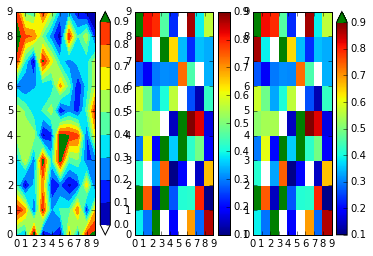

In [128]:
# Fiddling with the colorbar

x = np.arange(10)
y = np.arange(10)
z = np.random.rand(10,10)

plt.figure(figsize=(6, 4))

plt.subplot(1,3,1)
cs = plt.contourf(x,y,z,levels=np.arange(0, 1, 0.1), cmap=plt.cm.jet, extend="both")
cs.cmap.set_under('k')
cs.cmap.set_over('g')
cs.set_clim(0, 1)
cb = plt.colorbar(cs)

plt.subplot(1,3,2)
cs = plt.pcolormesh(x,y,z, cmap=plt.cm.jet)
cs.cmap.set_under('k')
cs.cmap.set_over('g')
cs.set_clim(0.1, 0.9)
cb = plt.colorbar(cs)

plt.subplot(1,3,3)
cs = plt.pcolormesh(x,y,z, cmap=plt.cm.jet)
cs.cmap.set_under('white')
cs.cmap.set_over('g')
cs.set_clim(0.1, 0.9)
cb = plt.colorbar(cs, extend="max")



In [ ]:
# Read in hourly data from virtual mooring in the Celtic Sea. Choose ST4.
ls /projectsa/FASTNEt/kariho40/AMM60/RUNS/D376/AMM60_1h_2012*ST4*nc

RUNS/D376/AMM60_1h_20120504_20120608_fastnet_ST4_grid_T.nc  
RUNS/D376/AMM60_1h_20120504_20120610_fastnet_ST4_grid_T.nc  
RUNS/D376/AMM60_1h_20120611_20120702_fastnet_ST4_grid_T.nc  

Do the lines overlap? If so then may as well stick to the longer files
Edit *.py file with SSH moorings files
Edit *.py files with plotting time, and limits, on x-axis


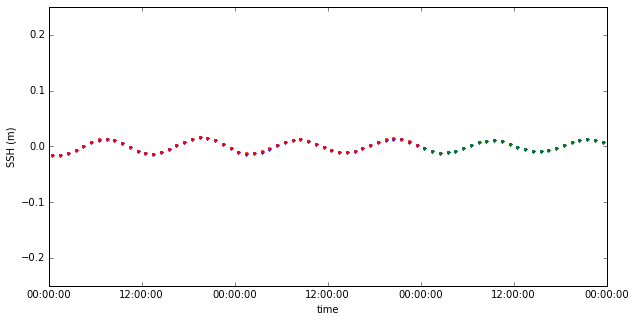

In [10]:
### Check that the SSH times series are consistent across overlapping files
import datetime

fullfilepath1 = '/projectsa/FASTNEt/kariho40/AMM60/RUNS/D376/AMM60_1h_20120504_20120610_fastnet_ST4_grid_T.nc'
fullfilepath2 = '/projectsa/FASTNEt/kariho40/AMM60/RUNS/D376/AMM60_1h_20120611_20120702_fastnet_ST4_grid_T.nc'

fullfilepath3 = '/projectsa/FASTNEt/kariho40/AMM60/RUNS/2010_2013/NO_DIFF/AMM60_1h_20120421_20120619_fastnet_ST4_grid_T.nc'
fullfilepath4 = '/projectsa/FASTNEt/kariho40/AMM60/RUNS/2010_2013/NO_DIFF/AMM60_1h_20120620_20120818_fastnet_ST4_grid_T.nc'


# load in time and depth
f = Dataset(fullfilepath1)
depth_1 = f.variables['depth'][:] # (time_counter, deptht, y, x)
depth_1 = depth_1 - np.mean(depth_1, axis=0)
time_counter_1  = f.variables['time_counter'][:]
[time_str, time_datetime_1, flag_err] = NEMO_fancy_datestr( time_counter_1, time_origin )



# load in time and depth
f = Dataset(fullfilepath2)
depth_2 = f.variables['depth'][:] # (time_counter, deptht, y, x)
depth_2 = depth_2 - np.mean(depth_2, axis=0)
time_counter_2  = f.variables['time_counter'][:]
[time_str, time_datetime_2, flag_err] = NEMO_fancy_datestr( time_counter_2, time_origin )


# load in time and depth
f = Dataset(fullfilepath3)
depth_3 = f.variables['depth'][:] # (time_counter, deptht, y, x)
depth_3 = depth_3 - np.mean(depth_3, axis=0)
time_counter_3  = f.variables['time_counter'][:]
[time_str, time_datetime_3, flag_err] = NEMO_fancy_datestr( time_counter_3, time_origin )



# load in time and depth
f = Dataset(fullfilepath4)
depth_4 = f.variables['depth'][:] # (time_counter, deptht, y, x)
depth_4 = depth_4 - np.mean(depth_4, axis=0)
time_counter_4  = f.variables['time_counter'][:]
[time_str, time_datetime_4, flag_err] = NEMO_fancy_datestr( time_counter_4, time_origin )



# Plot MLD timeseries
fig = plt.figure()
plt.rcParams['figure.figsize'] = (10.0, 5.0)

plt.plot(time_datetime_3, depth_3[:,-1,1,1],'b.')
plt.plot(time_datetime_4, depth_4[:,-1,1,1],'k.')

plt.plot(time_datetime_1, depth_1[:,-1,1,1],'r.')
plt.plot(time_datetime_2, depth_2[:,-1,1,1],'g.')
plt.ylim([-0.25, 0.25])
plt.ylabel('SSH (m)' )
plt.xlabel('time')
dstart = datetime.datetime(2012,6,9)
dend = datetime.datetime(2012,6,12)
#dstart = datetime.datetime(2012,4,15)
#dend = datetime.datetime(2012,8,25)
plt.xlim(dstart, dend)

print 'Do the lines overlap? If so then may as well stick to the longer files. YES. Not perfect but close.'
print 'Edit *.py file with SSH moorings files'
print 'Edit *.py files with plotting time, and limits, on x-axis'

In [ ]:
/projectsa/FASTNEt/jelt/AMM60/RUNS/2010_2013/IT
livljobs2 IT $ 
livljobs2 IT $ ls -lrt
total 43043072
-rwxr-x---. 1 jelt pol  632290027 Sep 30 08:17 AMM60_1h_20120601_20120601_diagIT_grid_T.nc
-rwxr-x---. 1 jelt pol 6206250563 Sep 30 08:19 AMM60_1h_20120601_20120610_diagIT_grid_T.nc
-rwxr-x---. 1 jelt pol 6206250563 Sep 30 08:20 AMM60_1h_20120611_20120620_diagIT_grid_T.nc
-rwxr-x---. 1 jelt pol 6206250563 Sep 30 08:21 AMM60_1h_20120621_20120630_diagIT_grid_T.nc
-rwxr-x---. 1 jelt pol 6206250563 Sep 30 08:23 AMM60_1h_20120701_20120710_diagIT_grid_T.nc
-rwxr-x---. 1 jelt pol 6206250563 Sep 30 08:24 AMM60_1h_20120711_20120720_diagIT_grid_T.nc
-rwxr-x---. 1 jelt pol 6206250563 Sep 30 08:25 AMM60_1h_20120721_20120730_diagIT_grid_T.nc
-rwxr-x---. 1 jelt pol 6206250563 Sep 30 08:27 AMM60_1h_20120731_20120809_diagIT_grid_T.nc

In [2]:
profile = []